<a href="https://colab.research.google.com/github/Andysimps0n/DL_lecture/blob/main/Linear_reg_And_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Pytorch (For Google Colab)

In [75]:
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)

ERROR: Could not find a version that satisfies the requirement torch==1.0.0 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0, 2.9.1, 2.10.0)
ERROR: No matching distribution found for torch==1.0.0
2.9.0+cpu


### 1. Data Generation  (Preparation)

Regression 실습에 사용할 데이터를 만들어봅시다. 이번에는 X가 2차원 Y가 1차원인 상황입니다.  
아래 관계를 따르는 데이터 분포가 있으며 관측시 발생한 오차가 $e$가 더해져 있다고 합시다.  
$sin(x)$ 함수와 $log(x)$ 함수 모두 쉽게 생각할 수 있는 non-linear 함수이죠!  

$$ e \sim \mathcal{N} (0, 0.5) $$
$$y = \ 2 sin(x_1) + log({1 \over 2}x_2^2) + e$$  


**Data Set**  
$$X_{train} \in \mathcal{R}^{1600 \times 2}, Y_{train} \in \mathcal{R}^{1600}$$  
$$X_{val} \in \mathcal{R}^{400 \times 2}, Y_{val} \in \mathcal{R}^{400}$$  
$$X_{test} \in \mathcal{R}^{400 \times 2}, Y_{test} \in \mathcal{R}^{400}$$

X, Y 데이터를 3D 공간에 시각화 해볼까요?  
`numpy`의 `random.rand()` 함수를 사용하면 n개의 랜덤 샘플을 0~1의 uniform distribution에서 샘플링할 수 있습니다.

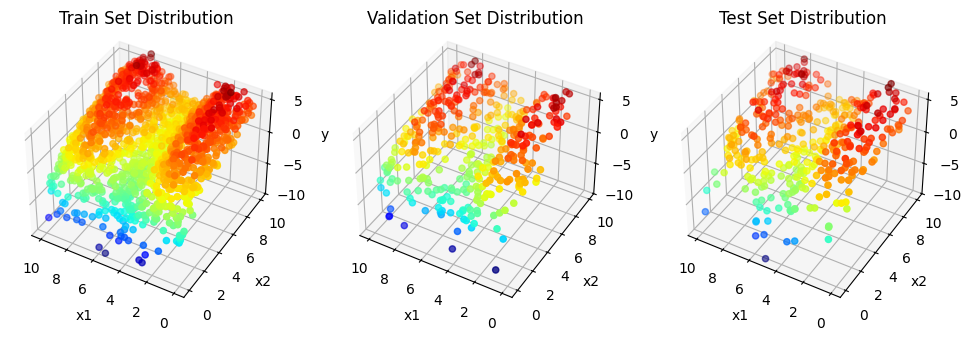

In [93]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# ====== Generating Dataset ====== #
num_data = 2400
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10
e = np.random.normal(0, 0.5, num_data)
X = np.array([x1, x2]).T
# y = x1
y = 2*np.sin(x1) + np.log(0.5*x2**2) + e
# ====== Split Dataset into Train, Validation, Test ======#
train_X, train_y = X[:1600, :], y[:1600]
val_X, val_y = X[1600:2000, :], y[1600:2000]
test_X, test_y = X[2000:, :], y[2000:]

# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(train_X[:, 0], train_X[:, 1], train_y, c=train_y, cmap='jet')

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
ax1.set_title('Train Set Distribution')
ax1.set_zlim(-10, 6)
ax1.view_init(40, -60)
ax1.invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(val_X[:, 0], val_X[:, 1], val_y, c=val_y, cmap='jet')

ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')
ax2.set_title('Validation Set Distribution')
ax2.set_zlim(-10, 6)
ax2.view_init(40, -60)
ax2.invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')

ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('y')
ax3.set_title('Test Set Distribution')
ax3.set_zlim(-10, 6)
ax3.view_init(40, -60)
ax3.invert_xaxis()

plt.show()

### 2. Hypothesis Define (Model Define)  

Linear Regression 시에 활용하는 H(x) = Wx + b를 파이토치로 구현할 때는 단순하게 `nn.Linear` 모듈을 하나 만들어주면 됩니다. 이 때`in_features`는 x의 차원이고, `out_features`는 y의 차원입니다.  


**Linear Model**   
$$H = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 1}, b \in \mathcal{R}^{1}, H \in \mathcal{R}^{N \times 1})$$


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200})$$  

$$H = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 1}, b_2 \in \mathcal{R}^{1}, H \in \mathcal{R}^{N  \times 1})$$

In [84]:
import torch
import torch.nn as nn


class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=1, bias=True)

    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        return self.linear(x)


class MLPModel(nn.Module):
  def __init__(self, layer_num=None, nodes=None):
    super(MLPModel, self).__init__()

    if layer_num == None:
      layer_num = len(nodes)

    if nodes == None :
      nodes = [2**i for i in range(layer_num+1)]

    module_list = [ nn.Linear(nodes[i],nodes[i+1]) for i in range(len(nodes)-1)]


    self.layers = nn.ModuleList(module_list)
    self.activation = nn.ReLU()


  def forward(self, x):
    for layer in self.layers[:-1]:
      x = layer(x)
      x = self.activation(x)

    x = self.layers[-1](x)
    return x

In [78]:
arr = [2, 32, 64, 1]

for i in range(len(arr)-1):
  print(arr[i], arr[i+1])

2 32
32 64
64 1


In [79]:
model = MLPModel(nodes=[2, 32, 64, 1])

print(model)

MLPModel(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (activation): ReLU()
)


In [80]:
torch.save(model, "my_model.pth")

### 3. Cost Function Define (Loss Function Define)  

Regression Problem 에서의 Loss Function을 작성해봅시다.  
파이토치의 `nn` 아래에는 다양한 Loss Function이 이미 구현되어 있습니다.  
[여기](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html)에서 파이토치 내부에 구현되어 있는 MSE, Cross-Entropy, KL-Divergence 등을 확인할 수 있습니다.  
이 실습에서는 Regression Problem 이므로 Mean Squared Error 즉 MSE Loss를 써봅시다.

In [81]:
reg_loss = nn.MSELoss()

test_pred_y = torch.Tensor([0,0,0,0])
test_true_y = torch.Tensor([0,1,0,1])

print(reg_loss(test_pred_y, test_true_y))
print(reg_loss(test_true_y, test_true_y))


tensor(0.5000)
tensor(0.)


### 4. Train & Evaluation
이제 모델도 정의했고 Loss Function도 정의했으니 한번 학습시켜볼까요?  
저번에는 저희가 직접 파라미터(w 하나)에 따른 loss의 편미분을 유도하고 거기서 나온 그라디언트로 w를 업데이트했는데요.  
`pytorch`에서는 loss.backward() 라는 기능을 쓰면 알아서 loss를 계산되는데 사용한 각 파라미터에 대한 loss의 편미분을 계산해줍니다.  
이후 `optimizer.step()` 함수를 사용하면 각 파라미터의 그라디언트를 바탕으로 파라미터의 값을 조금씩 업데이트 해줍니다.

이 때 모델은 매 Iteration 때마다 Train Set에 의해 학습되면서 동시에 Validation Set을 넣고 Loss를 비교하게됩니다.
그리고 저희가 평가하고 싶은 때마다 (지금은 200번) Test Set을 넣고 Visualize 하는데 필요한 Predicted y값과 Metric 값을 계산합니다. 여기서 Metric으로는 mean absolute error(MAE)를 활용해보죵  

$$MAE(Y_{true}, Y_{predict}) = \sum_{i} | \ y_{true}^{(i)} - y_{predict}^{(i)} \ | $$

In [82]:
model = LinearModel()
print(model.linear.weight)
print(model.linear.bias)

Parameter containing:
tensor([[-0.2636,  0.6666]], requires_grad=True)
Parameter containing:
tensor([-0.2576], requires_grad=True)


801 parameters


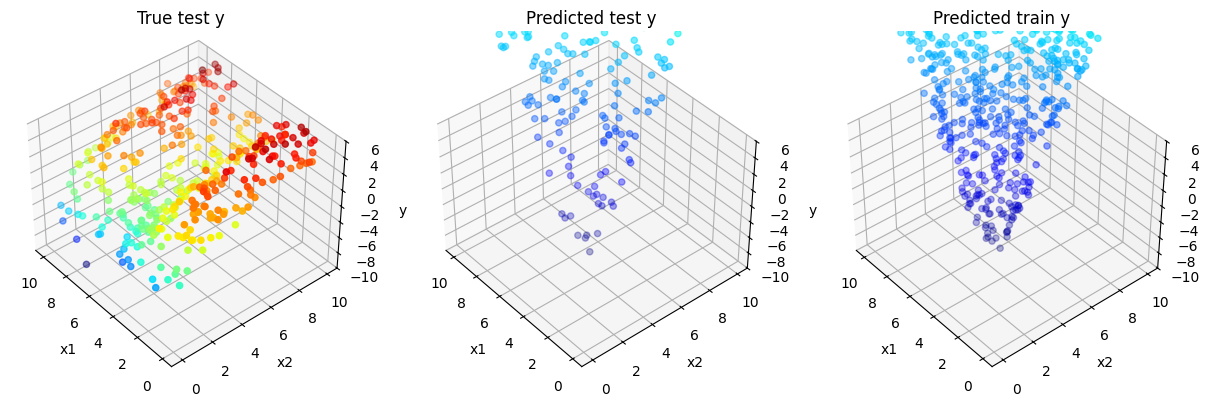

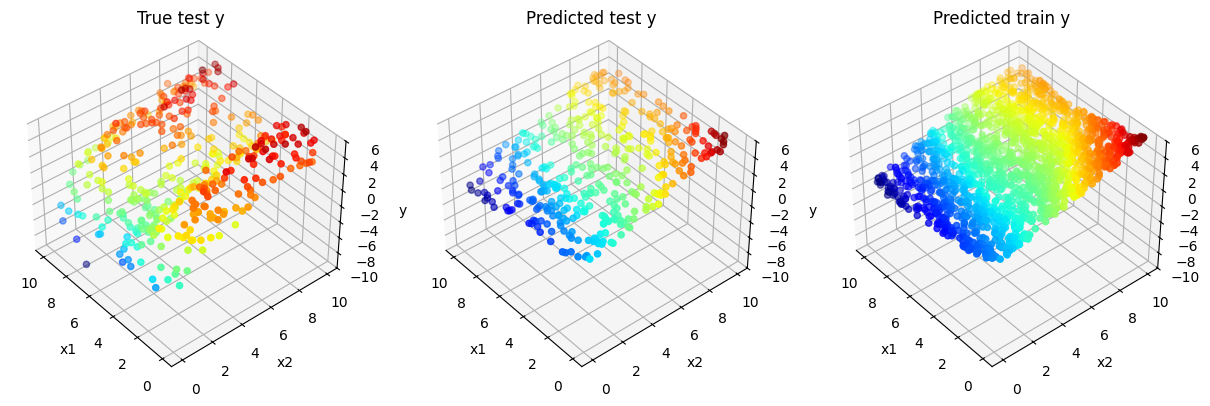

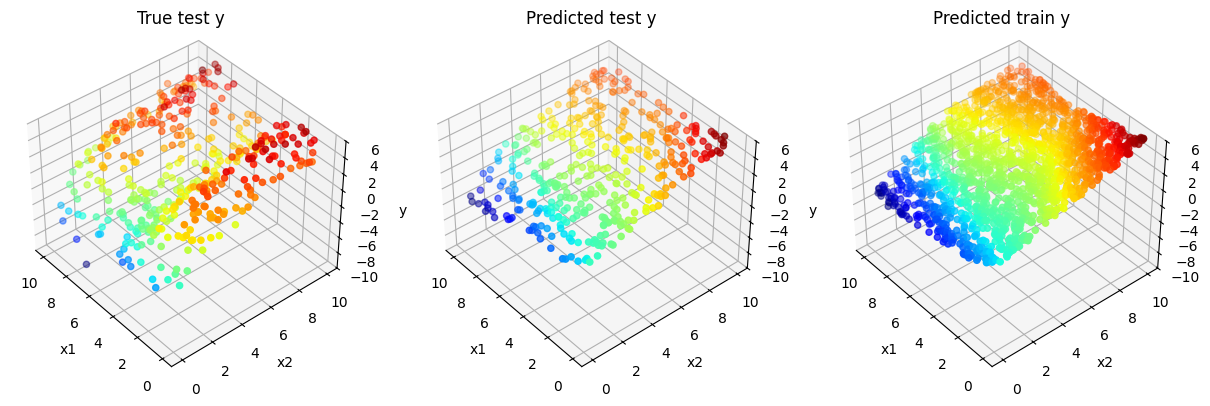

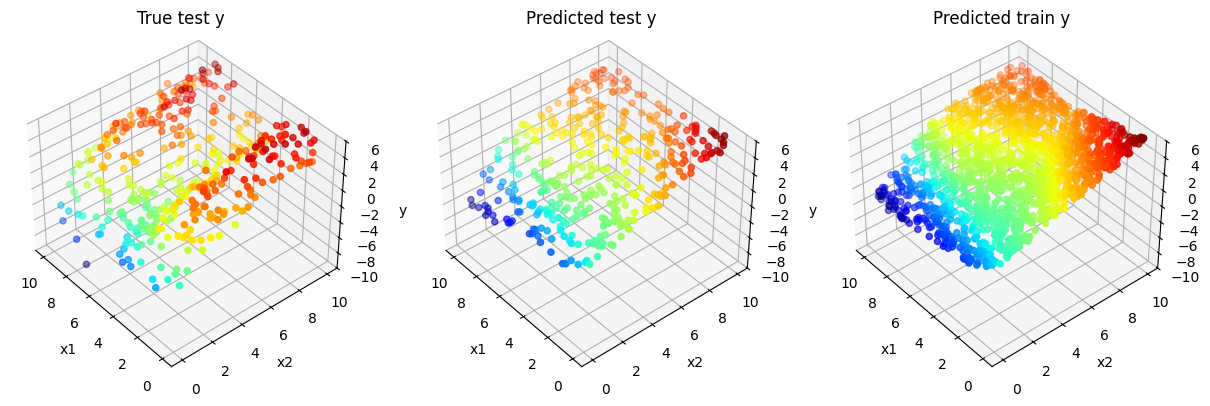

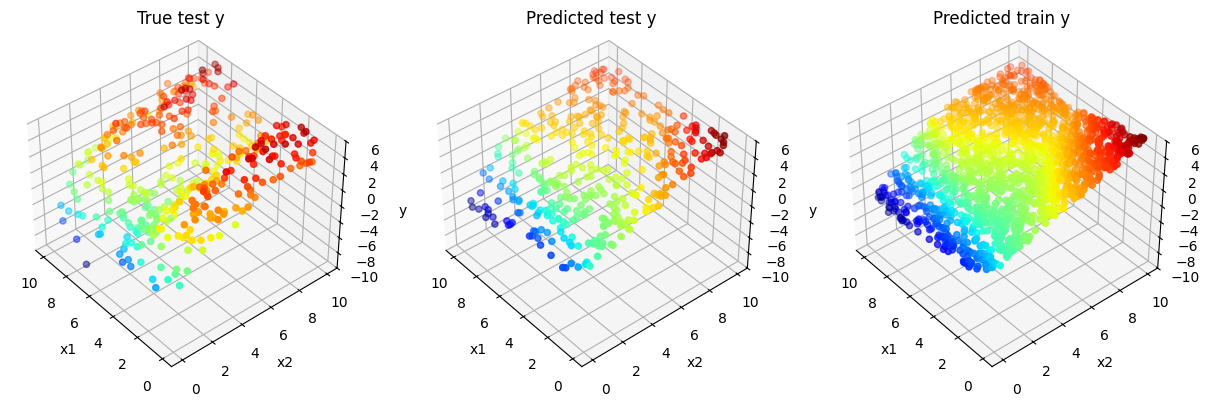

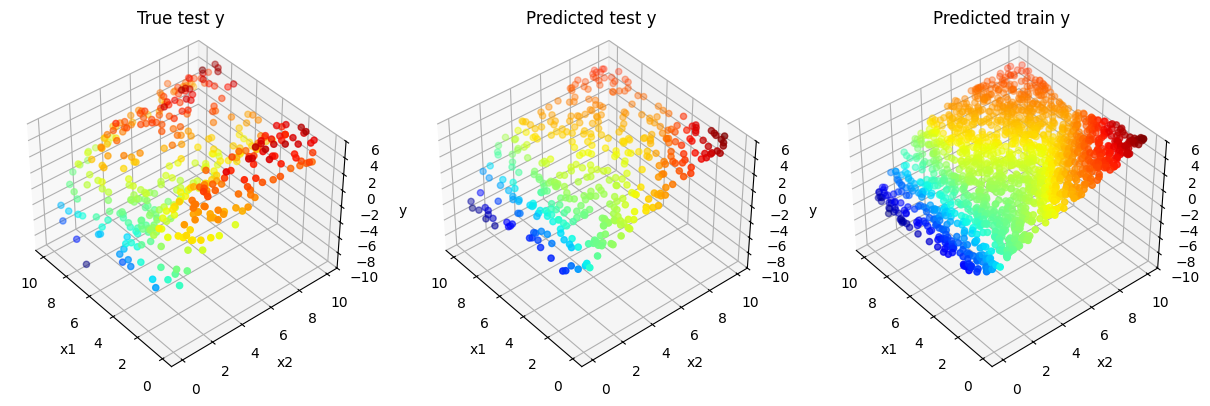

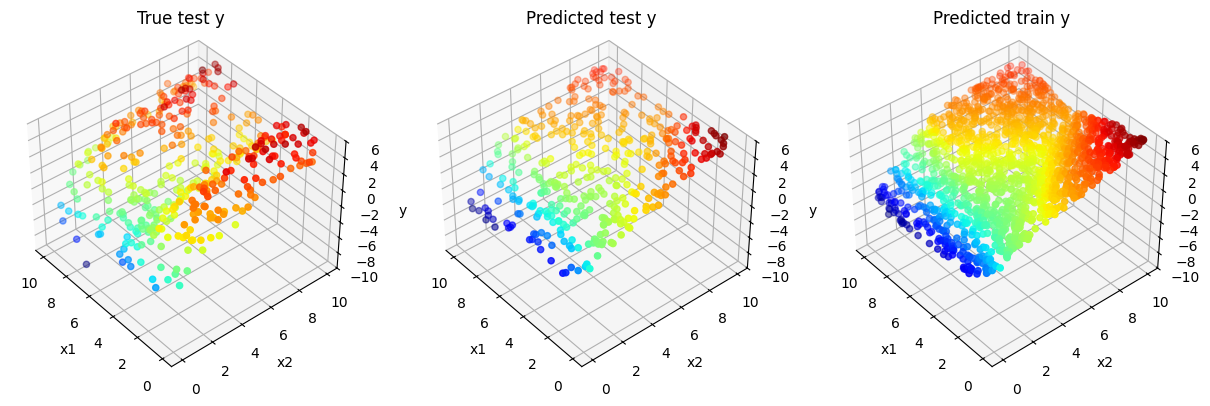

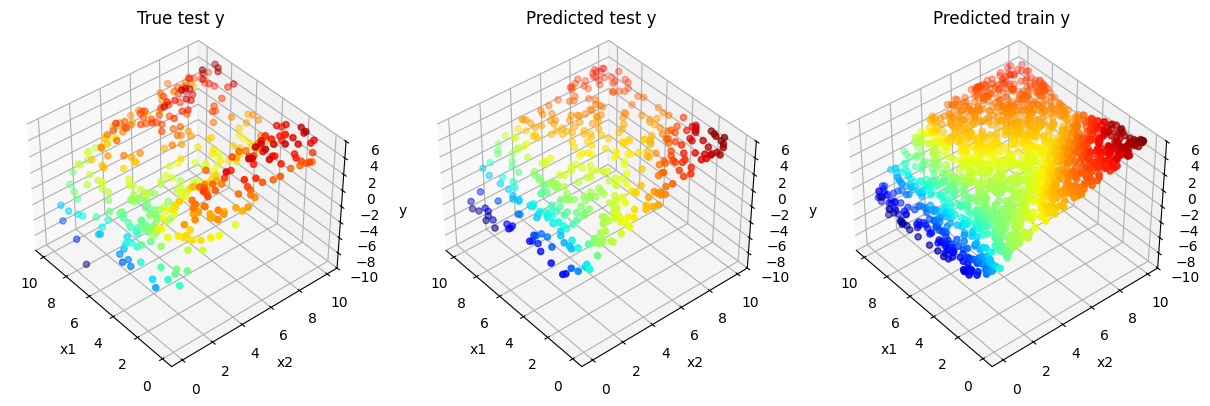

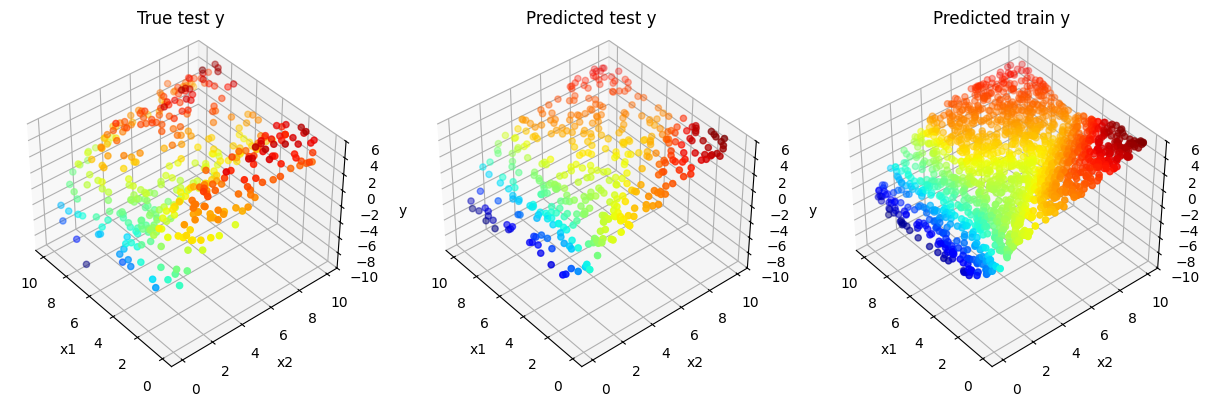

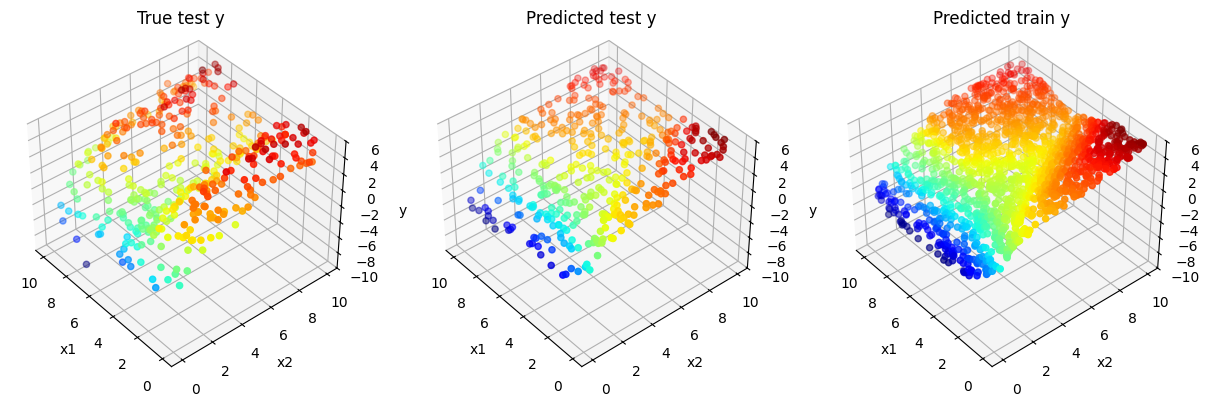

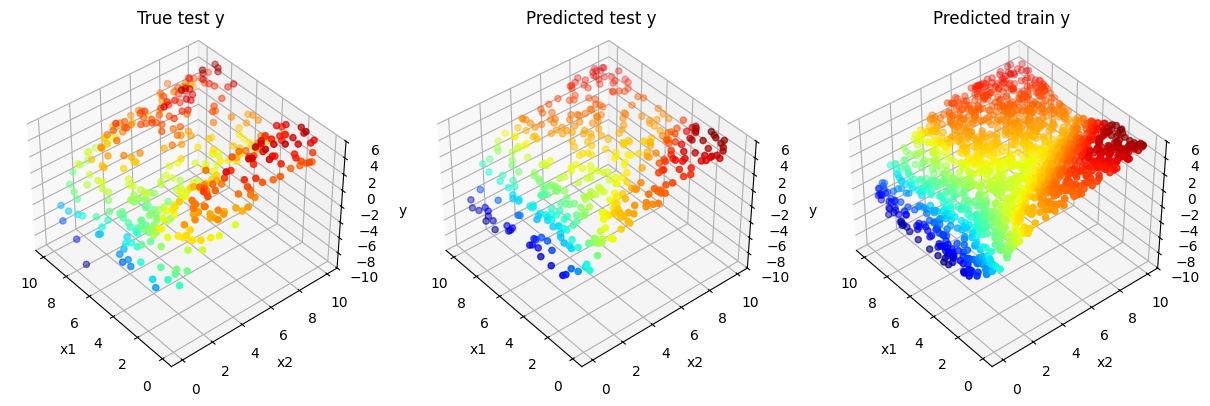

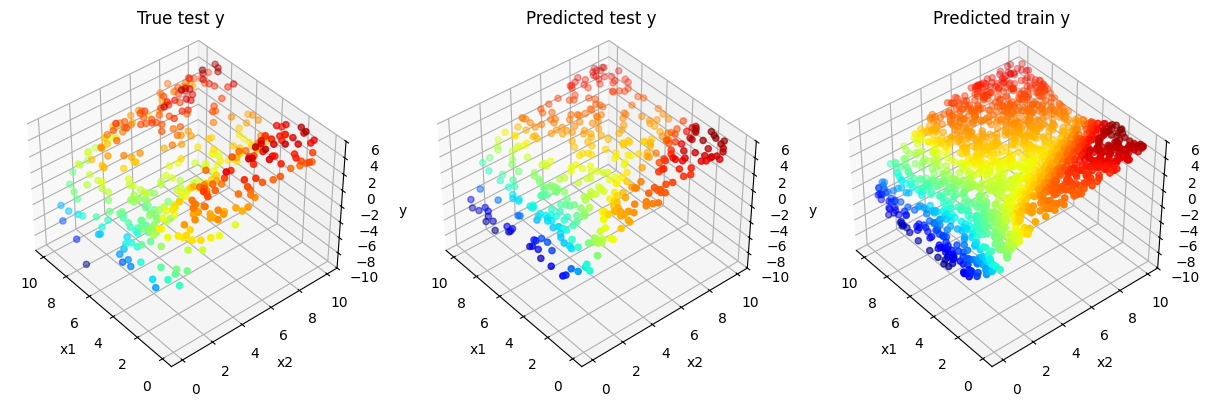

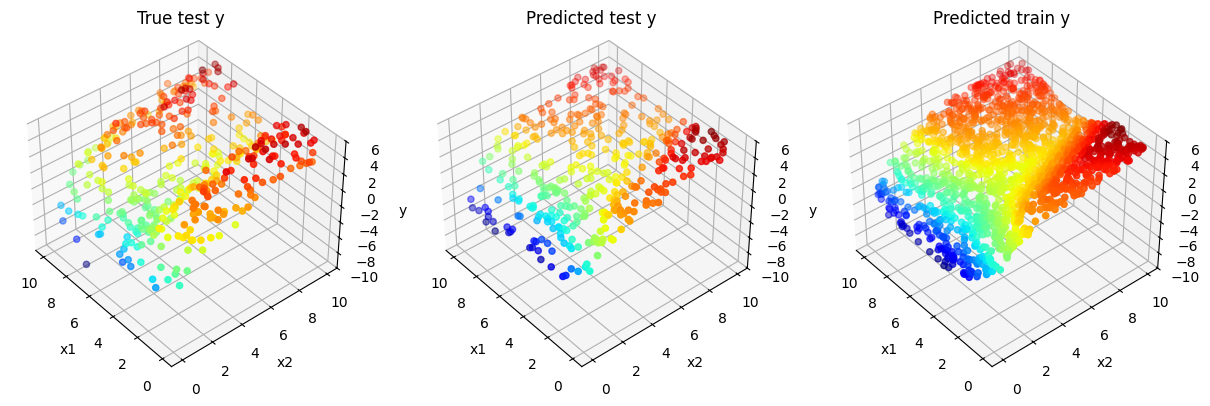

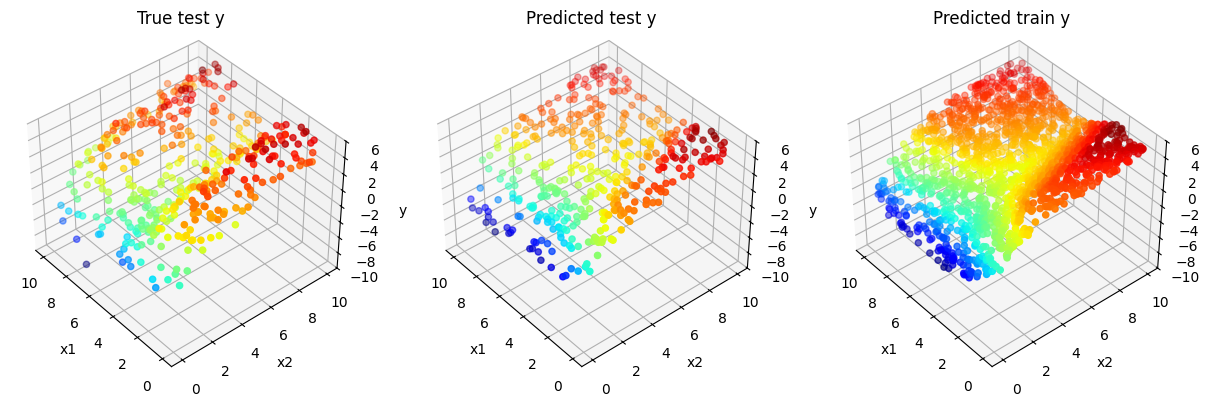

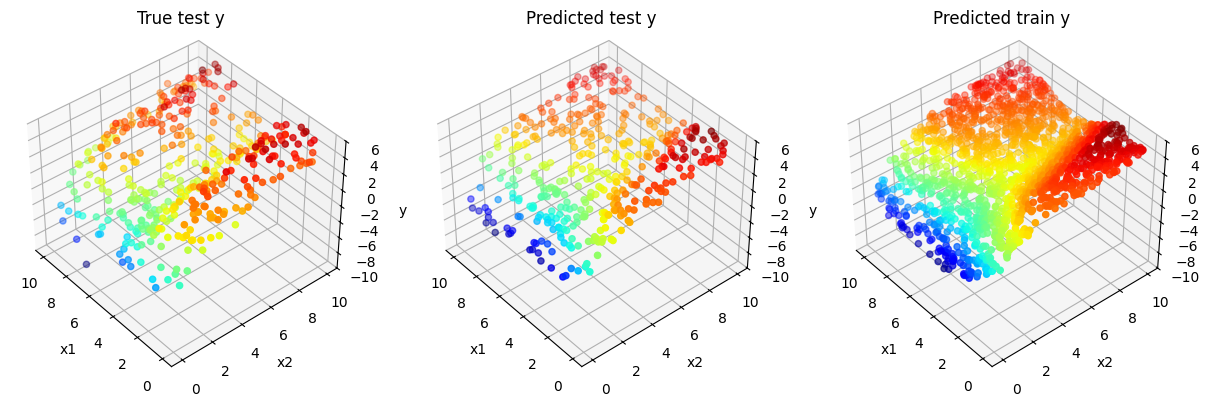

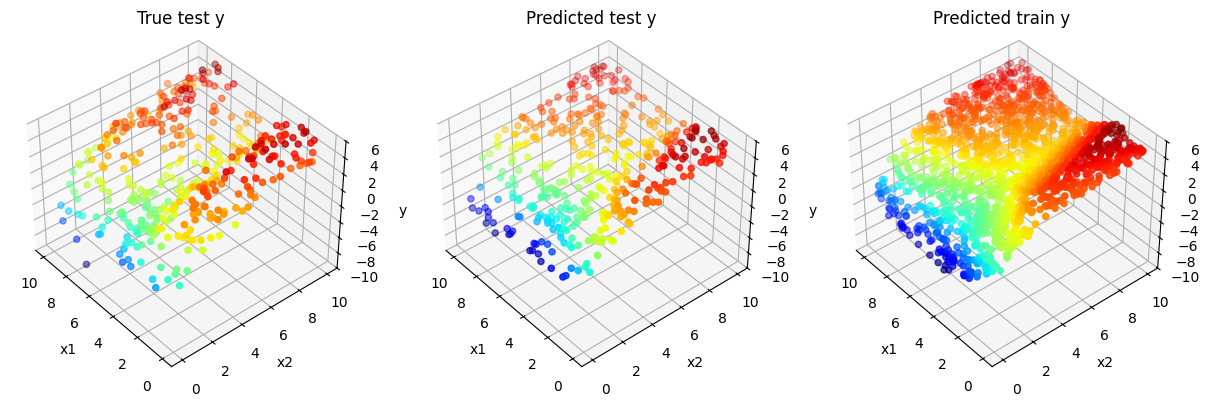

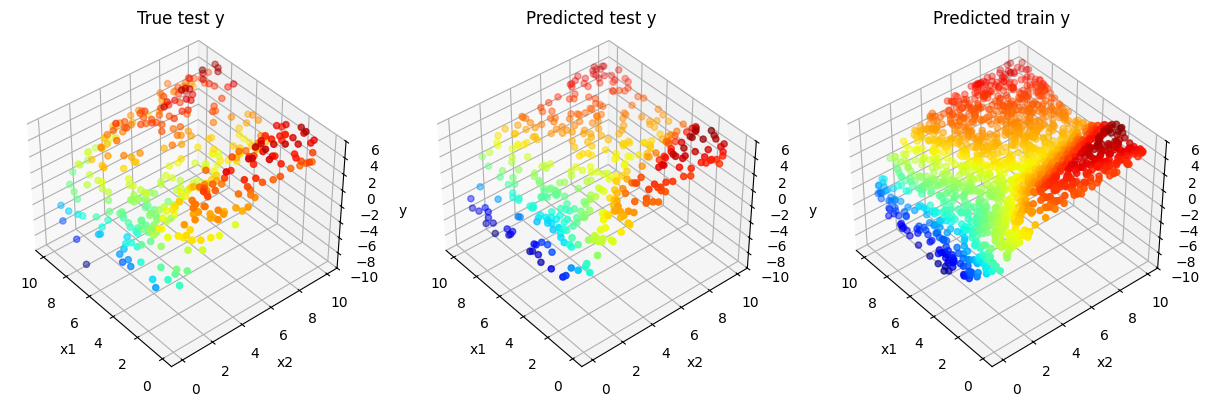

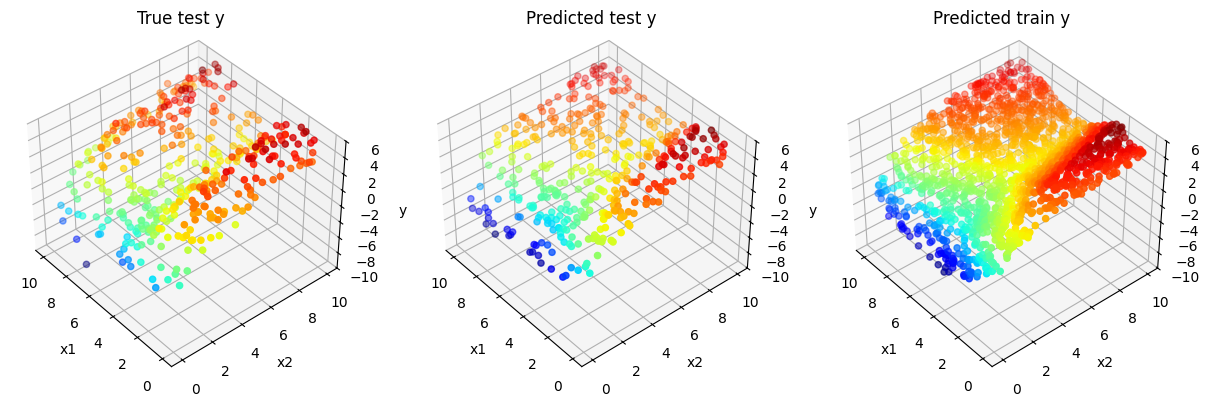

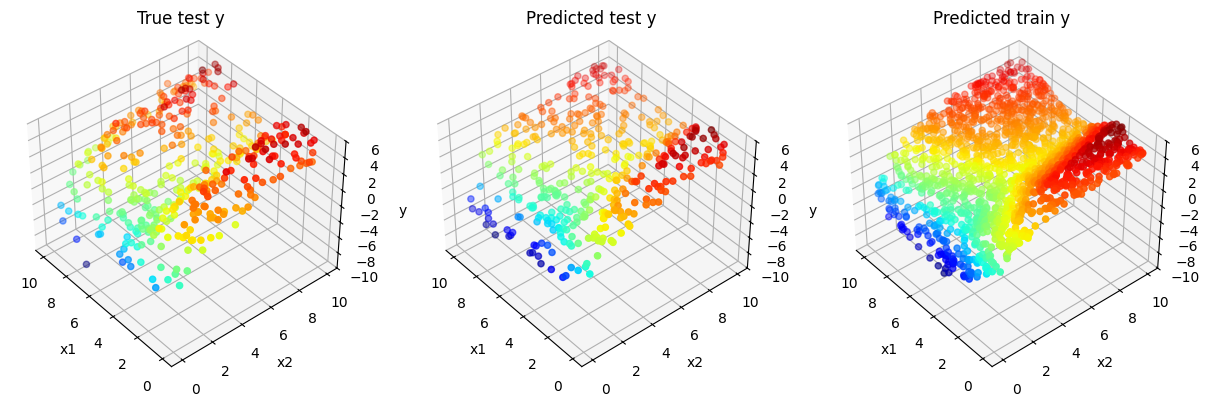

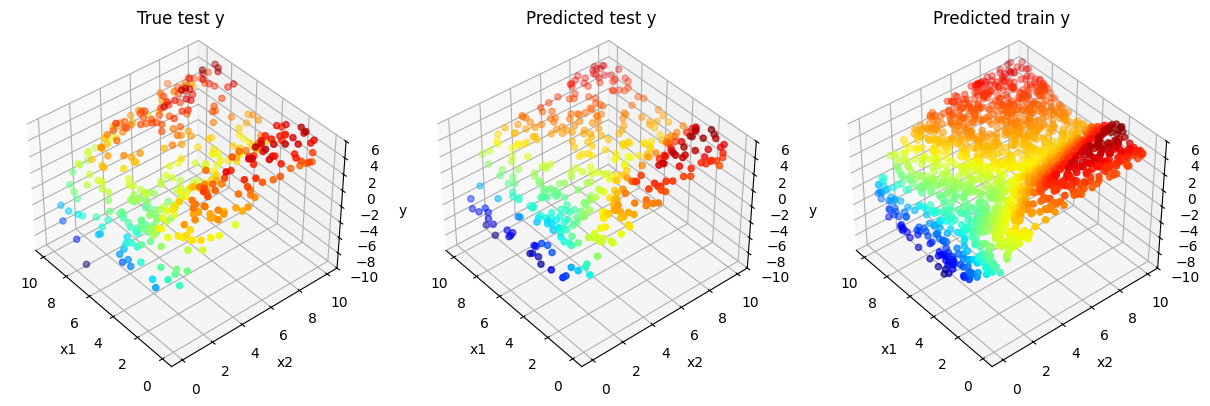

In [90]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error


# ====== Construct Model ====== #


model = MLPModel(nodes=[2, 200, 1])
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만들어줍시다.
list_epoch = []
list_train_loss = []
list_val_loss = []
list_mae = []
list_mae_epoch = []


input_x = torch.Tensor(train_X)
true_y = torch.Tensor(train_y)
pred_y = model(input_x)

epoch = 4000 # 학습 횟수(epoch)을 지정해줍시다.
for i in range(epoch):

    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다)
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.

    loss = reg_loss(pred_y.view(-1), true_y.view(-1))  # (1600,)이랑 (1600, 1)의 크기를 통일
    loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
    optimizer.step() # step()을 통해서 그라디언틀를 바탕으로 파라미터를 업데이트 해줍니다.
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())


    # ====== Validation ====== #

    # 이 세 줄은 학습이랑 확실히 분리하려고 있음
    model.eval()
    optimizer.zero_grad()
    loss = reg_loss(pred_y.view(-1), true_y.view(-1))

    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y)
    pred_y = model(input_x)
    list_val_loss.append(loss.detach().numpy())


    # ====== Evaluation ======= #
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.

        # ====== Calculate MAE ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().numpy()
        mae = mean_absolute_error(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
        list_mae.append(mae)
        list_mae_epoch.append(i)

        fig = plt.figure(figsize=(15,5))

        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')

        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('y')
        ax1.set_zlim(-10, 6)
        ax1.view_init(40, -40)
        ax1.set_title('True test y')
        ax1.invert_xaxis()

        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')

        # Predicted Y Scattering 부분 수정
        pred_y_plot = pred_y.flatten() # 1차원으로 쭉 폅니다.

        # ax2.scatter 호출 시 c 인자 확인
        ax2.scatter(test_X[:, 0], test_X[:, 1], pred_y_plot, c=pred_y_plot, cmap='jet')

        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_zlabel('y')
        ax2.set_zlim(-10, 6)
        ax2.view_init(40, -40)
        ax2.set_title('Predicted test y')
        ax2.invert_xaxis()





        # ====== Just for Visualizing with High Resolution (ax3) ====== #
        input_x = torch.Tensor(train_X)
        # model(input_x)의 결과가 [1600, 1]일 것이므로 flatten()으로 [1600]으로 변환
        pred_y_train = model(input_x).detach().numpy().flatten()

        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        # 이제 pred_y_train은 1차원이므로 c 인자와 데이터 개수가 일치합니다.
        ax3.scatter(train_X[:, 0], train_X[:, 1], pred_y_train, c=pred_y_train, cmap='jet')

        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_zlabel('y')
        ax3.set_zlim(-10, 6)
        ax3.view_init(40, -40)
        ax3.invert_xaxis()
        ax3.set_title('Predicted train y')

### 5. Report Experiment  
학습 과정에서 기록했던 train_loss와 val_loss를 그려봅시다.   
Loss가 꾸준히 줄어드는지 확인하고 val_loss가 증가하기 시킨다면 그 이상의 학습은 점점 모델의 성능을 망침을 뜻합니다.
그 옆에는 Epoch에 따라서 MAE metric이 얼마나 감소하는지 확인해봅시다.

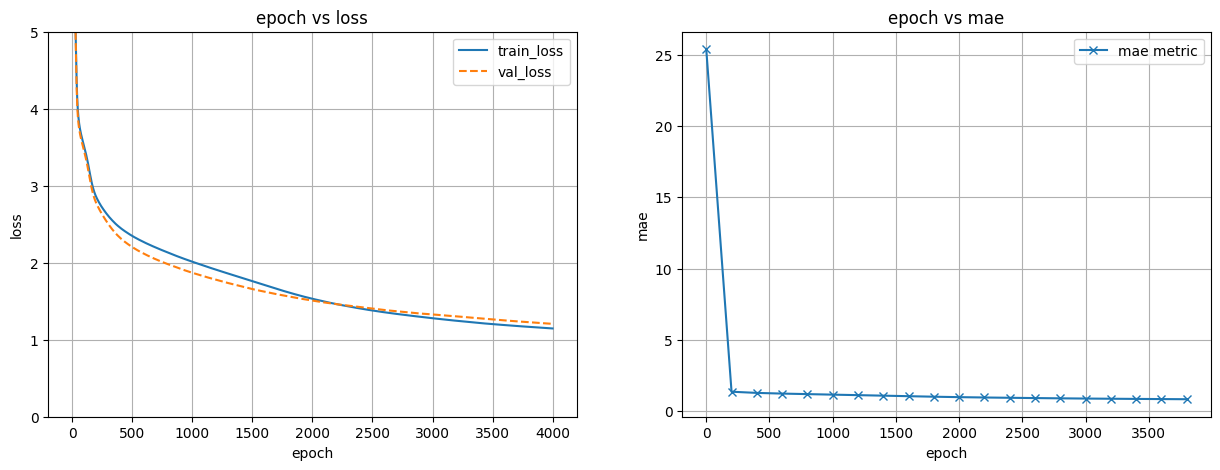

In [94]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_mae_epoch, list_mae, marker='x', label='mae metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('mae')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs mae')


plt.show()